# Create Text Classfier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from tensorflow import keras
import re
np.random.seed(4864)

Lets try a Naive bayes model.

naive Bayes regularly generalizes well into data as it is a high bias model, with low variance

This means it is not a very complex model and does not often overfit to the training set which is a great place for us to start

In [241]:
def cleanse(row):
    row_clean = row.replace("-", " ")
    row_clean = re.sub("[\n]", " ",row_clean)
    row_clean = re.sub("[.!?/\()-,:]", "",row_clean)
    row_clean = row_clean.lower()
    return row_clean

def clean_df(df):
    text = []
    target = []
    for row in df.iterrows():
            row_clean = cleanse(row[1][1])
            text.append(row_clean)
    out = pd.DataFrame({'text':text,"target":df.out})
    return out

            

In [242]:
#Create data partitions
df = pd.read_csv(f'../data/labeled_data.csv', encoding='latin-1')
df = df.dropna()
df = clean_df(df)
X_train, X_test, y_train, y_test=train_test_split(df.text, df.target, test_size=0.25)

Transform data into sklearns compressed count vector format 

In [243]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
X_train_counts.shape,X_test_counts.shape

((1375, 3085), (459, 3085))

Transform data into frequencies rather than raw count to avoid extreme outliars.

In [244]:

freq_transformer = TfidfTransformer(use_idf=False)
X_train_freq = freq_transformer.fit_transform(X_train_counts)
X_test_freq = freq_transformer.transform(X_test_counts)


Train model with training set

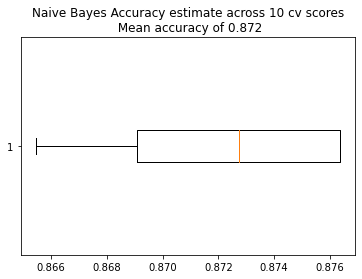

In [245]:
naive = MultinomialNB()
samples = X_train_freq.shape[0]
scores = cross_val_score(naive,X_train_freq,y_train,cv = 5)
naive_classifier = naive.fit(X_train_freq,y_train)
acc = np.round(np.mean(scores),3)

blue_diamond = dict(markerfacecolor='b', marker='D')
plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"Naive Bayes Accuracy estimate across 10 cv scores\n Mean accuracy of {acc}")
plt.show()

Seems like we have achieved great accuracy on our first model. 

We will keep in this in mind but lets try a support vector machine classifier to see if we can gather improvement in training accuracy 

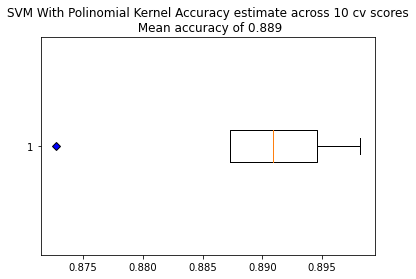

In [246]:
vector_machine = svm.SVC(kernel='poly')
vector_classifier = vector_machine.fit(X_train_freq,y_train)
scores = cross_val_score(vector_machine,X_train_freq,y_train,cv = 5)
acc = np.round(np.mean(scores),3)

plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"SVM With Polinomial Kernel Accuracy estimate across 10 cv scores\n Mean accuracy of {acc}")
plt.show()

Seems like the svm with a polynomial kernel achieves similar accuracy estimate on the training set 

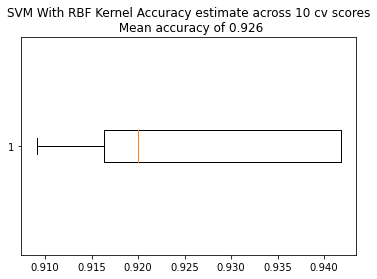

In [247]:
vector_machine_rbf = svm.SVC(kernel='rbf')
vector_classifier_rbf = vector_machine.fit(X_train_freq,y_train)
scores = cross_val_score(vector_machine_rbf,X_train_freq,y_train,cv = 5)
acc = np.round(np.mean(scores),3)

plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"SVM With RBF Kernel Accuracy estimate across 10 cv scores\n Mean accuracy of {acc}")
plt.show()

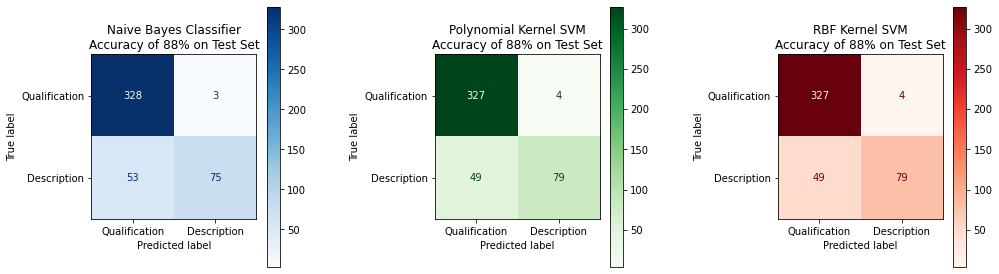

In [248]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

plot_confusion_matrix(naive_classifier,X_test_freq,y_test, display_labels=['Qualification','Description'],cmap=plt.cm.Blues,ax = ax1)
ax1.set_title(f"Naive Bayes Classifier\nAccuracy of {naive_classifier.score(X_test_freq,y_test) *100 :.0f}% on Test Set")

plot_confusion_matrix(vector_classifier,X_test_freq,y_test, display_labels=['Qualification','Description'],cmap=plt.cm.Greens,ax=ax2)
ax2.set_title(f"Polynomial Kernel SVM\nAccuracy of {vector_classifier.score(X_test_freq,y_test) *100 :.0f}% on Test Set")


plot_confusion_matrix(vector_classifier_rbf,X_test_freq,y_test, display_labels=['Qualification','Description'],cmap=plt.cm.Reds,ax=ax3)
ax3.set_title(f"RBF Kernel SVM\nAccuracy of {vector_classifier_rbf.score(X_test_freq,y_test) *100 :.0f}% on Test Set")
fig.tight_layout(pad=5.0)
plt.show()


Seems like all models perform roughly the same on the test set.

This can be simply due to irregularities in data but essentially means all models generalize well to unseen data so we can proceed

Going forth I will dedicate the radial basis kernel svm model as the primary production model due to it achieving the highest cross validation accuracy estimate

In [249]:
import joblib
joblib.dump(vector_classifier_rbf,'classifier.pkl')
joblib.dump(count_vect,'count_vect.pkl')
joblib.dump(freq_transformer,'freq_transformer.pkl')

['freq_transformer.pkl']